# Exploration

In [1]:
# Load the data as a list of lists
with open('dataset_a1.txt', 'r') as file:
    sequences = [line.strip().split(', ') for line in file]

# Example: Print the first sequence
print(sequences[0])

['Receiving Request', 'First Assessment', 'Fraud Check', 'Decline']


In [2]:
print("Type of sequences:", type(sequences))
print("Type of first sequence:", type(sequences[0]))
print("Length of sequences:", len(sequences))

print("-" * 20)

# Data is list of lists, each inner list is a sequence
# Show average length of sequences
lengths = [len(seq) for seq in sequences]
average_length = sum(lengths) / len(lengths)
print("Average length of sequences:", average_length)

print("-" * 20)

# print all potential first steps in sequences
first_steps = set()
for seq in sequences:
    first_steps.add(seq[0])
print("Potential first steps in sequences:", first_steps)

print("-" * 20)

# print all potential second steps in sequences
second_steps = set()
for seq in sequences:
    if len(seq) > 1:  # check if there is a second step
        second_steps.add(seq[1])

print("Potential second steps in sequences:", second_steps)

print("-" * 20)

# print all potential third steps in sequences
third_steps = set()
for seq in sequences:
    if len(seq) > 2:  # check if there is a third step
        third_steps.add(seq[2])

print("Potential third steps in sequences:", third_steps)

print("-" * 20)

# print all potential fourth steps in sequences
fourth_steps = set()
for seq in sequences:
    if len(seq) > 3:  # check if there is a fourth step
        fourth_steps.add(seq[3])

print("Potential fourth steps in sequences:", fourth_steps)

print("-" * 20)

# print all potential last steps in sequences\
last_steps = set()
for seq in sequences:
    last_steps.add(seq[-1])
print("Potential last steps in sequences:", last_steps)

print("-" * 20)

# print all potential steps in sequences 
all_steps = set()
for seq in sequences:
    for step in seq:
        all_steps.add(step)
print("Potential steps in sequences:", all_steps)

print("-" * 20)

# print all potential steps in sequences with their counts
step_counts = {}
for step in all_steps:
    step_counts[step] = 0
for seq in sequences:
    for step in seq:
        step_counts[step] += 1

# order step_counts by count
step_counts = dict(sorted(step_counts.items(), key=lambda item: item[1], reverse=True))
print("Potential steps in sequences with their counts:", step_counts)

print("-" * 20)

# print all potential steps in sequences not using first or last steps
not_first_last_steps = set()
for seq in sequences:
    for step in seq[1:-1]:
        not_first_last_steps.add(step)
print("Potential steps in sequences not using first or last steps:", not_first_last_steps) 

print("-" * 20)

# print number of unique steps in sequences
print("Number of unique steps in sequences:", len(all_steps))

Type of sequences: <class 'list'>
Type of first sequence: <class 'list'>
Length of sequences: 100
--------------------
Average length of sequences: 6.03
--------------------
Potential first steps in sequences: {'Receiving Request'}
--------------------
Potential second steps in sequences: {'First Assessment'}
--------------------
Potential third steps in sequences: {'Fraud Check'}
--------------------
Potential fourth steps in sequences: {'Fraud Check', 'Decline', 'Accept'}
--------------------
Potential last steps in sequences: {'Fraud Check', 'Decline', 'Receiving Request', 'Send Contract', 'Offer Refused', 'First Assessment'}
--------------------
Potential steps in sequences: {'Fraud Check', 'Contact Customer', 'Accept', 'Decline', 'Receiving Request', 'Create Offer', 'Send Contract', 'Draw Contract', 'Offer Refused', 'First Assessment'}
--------------------
Potential steps in sequences with their counts: {'Fraud Check': 174, 'Receiving Request': 100, 'First Assessment': 95, 'Declin

# Use of support.py

In [3]:
import numpy as np
import os

import contextlib
import pandas as pd
from datetime import date, datetime

from pm4py.objects.petri_net.obj import PetriNet
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to
from pm4py.objects.petri_net.obj import Marking
from pm4py import conformance
from pm4py.utils import constants

constants.SHOW_PROGRESS_BAR = False

activities = [
    "Invisible 1",
    "Invisible 2",
    "Receiving Request",
    "First Assessment",
    "Fraud Check",
    "Accept",
    "Decline",
    "Create Offer",
    "Contact Customer",
    "Offer Refused",
    "Draw Contract",
    "Send Contract",
]

NR_PLACES = 9

# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
    res = []
    with open(path) as fi:
        for line in fi:
            res.append(line.strip().split(", "))

    # reformating the dataset to a pandas dataframe for pm4py compatibility
    df = pd.DataFrame(
        {
            "date": date.today(),
            "case:concept:name": [str(i) for i in range(len(res))],
            "concept:name": res,
        }
    )
    df["date"] = pd.to_datetime(df["date"])
    df = df.explode("concept:name")

    base_timestamp = datetime.now()
    df["time:timestamp"] = base_timestamp + pd.to_timedelta(df.index, unit="h")

    return df


DATASET = load_dataset("dataset_a1.txt")
NR_TRANSITIONS = len(activities)
NAMES_TO_TRANSITION = dict(zip(activities, range(NR_TRANSITIONS)))


def fitness(sol):
    matrix = list_to_array(sol)

    nr_violations = _get_nr_handcrafted_violations(matrix)
    alignment_score = _get_alignment_scores(matrix)
    return (alignment_score - nr_violations,)


def list_to_array(sol):
    return np.array(sol).reshape((NR_TRANSITIONS, 2))


def _get_nr_handcrafted_violations(matrix) -> int:
    nr_arrivals_to_first_place = (matrix[:, 1] == 0).sum()
    nr_departures_from_last_place = (matrix[:, 0] == NR_PLACES - 1).sum()
    nr_self_loops = (matrix[:, 0] == matrix[:, 1]).sum()
    nr_backwards_invisible = (matrix[:2, 0] > matrix[:2, 1] + 2).sum()
    nr_backwards_visible = (matrix[2:, 0] > matrix[2:, 1]).sum()

    return (
        nr_arrivals_to_first_place
        + nr_departures_from_last_place
        + nr_self_loops
        + nr_backwards_invisible
        + nr_backwards_visible
    )


def _get_alignment_scores(matrix) -> float:
    net, initial_marking, final_marking = matrix_to_petrinet(matrix)

    # Needed to redirect the output of the fitness_alignments function, which outputs a lot of text,
    with open(os.devnull, "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            try:
                fa = conformance.fitness_alignments(
                    log=DATASET,
                    petri_net=net,
                    initial_marking=initial_marking,
                    final_marking=final_marking,
                )
            except Exception as e:
                return -1

    alignment_score = fa["average_trace_fitness"]
    return alignment_score


# plot the Petri net
def sol_to_graphviz(sol, output_file="output.pdf"):
    matrix = list_to_array(sol)
    net, _, _ = matrix_to_petrinet(matrix)
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
    gviz = pn_visualizer.apply(net, parameters=parameters)
    pn_visualizer.save(gviz, output_file)


def matrix_to_petrinet(matrix):
    net = PetriNet("PETRINAS")

    places_dict = {}

    for place_nr in range(NR_PLACES):
        place = PetriNet.Place(name=f"p{place_nr}")
        net.places.add(place)
        places_dict[place_nr] = place

        if place_nr == 0:
            first_marking = Marking()
            first_marking[place] = 1

        if place_nr >= NR_PLACES - 1:
            last_marking = Marking()
            last_marking[place] = 1

    for row, activity in enumerate(activities):
        if activity.startswith("Invisible"):
            transition = PetriNet.Transition(name=activity)
        else:
            transition = PetriNet.Transition(name=activity, label=activity)
        net.transitions.add(transition)

        start, end = matrix[row]

        start_place = places_dict[start]
        add_arc_from_to(start_place, transition, net)

        end_place = places_dict[end]
        add_arc_from_to(transition, end_place, net)

    return net, first_marking, last_marking


In [4]:
data = load_dataset("dataset_a1.txt")

In [5]:
data

,date,case:concept:name,concept:name,time:timestamp
0,2025-04-25,0,Receiving Request,2025-04-25 14:18:44.587757
0,2025-04-25,0,First Assessment,2025-04-25 14:18:44.587757
0,2025-04-25,0,Fraud Check,2025-04-25 14:18:44.587757
0,2025-04-25,0,Decline,2025-04-25 14:18:44.587757
1,2025-04-25,1,Receiving Request,2025-04-25 15:18:44.587757
...,...,...,...,...
99,2025-04-25,99,Accept,2025-04-29 17:18:44.587757
99,2025-04-25,99,Create Offer,2025-04-29 17:18:44.587757
99,2025-04-25,99,Contact Customer,2025-04-29 17:18:44.587757
99,2025-04-25,99,Draw Contract,2025-04-29 17:18:44.587757


## MADE WITH AI

--- GA Parameters ---
Population Size (POP_SIZE): 100
Crossover Probability (CXPB): 0.7
Mutation Probability (MUTPB): 0.2
Number of Generations (NGEN): 20
Tournament Size (TOURNSIZE): 3
Attribute Mutation Probability (INDPB): 0.1
---------------------

gen	nevals	max     	avg     	min	std    
0  	100   	-2.78681	-9.94446	-17	3.02362
1  	90    	-1.75391	-7.14967	-14.7366	2.37783
2  	76    	-0.910084	-5.30913	-10     	1.65933
3  	72    	-1.73658 	-4.19063	-8      	1.43498
4  	67    	-0.608285	-3.28926	-7      	1.23755
5  	74    	0.634249 	-2.60091	-7.78096	1.32179
6  	64    	-0.550137	-2.21981	-8      	1.17044
7  	73    	0.451322 	-1.66654	-6.69153	1.16296
8  	69    	0.5197   	-1.18917	-5.74762	1.00619
9  	61    	0.5197   	-0.971732	-7      	1.10673
10 	79    	0.559041 	-0.717121	-8      	1.34028
11 	75    	0.558763 	-0.232014	-4.72695	0.889416
12 	82    	0.554386 	-0.210041	-5      	1.11089 
13 	79    	0.558763 	0.173431 	-2.43915	0.534478
14 	78    	0.558763 	0.0927427	-4.6069 	0.89570

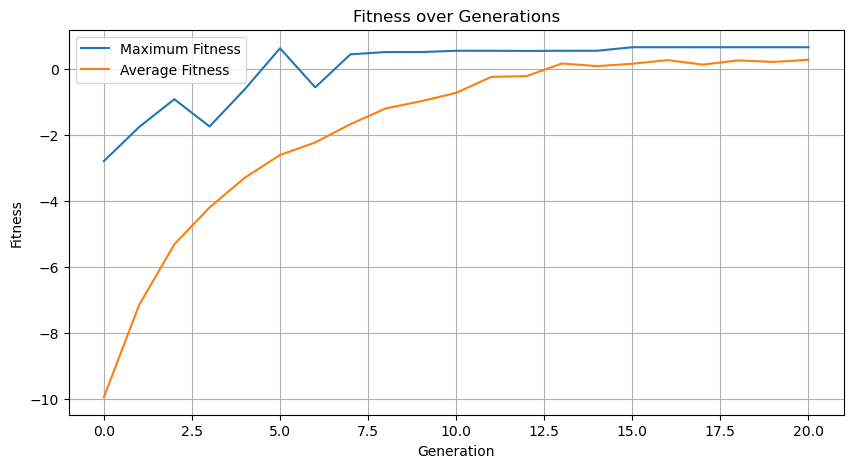

In [ ]:
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np

# Ensure necessary variables from the previous cell are available
# NR_TRANSITIONS, NR_PLACES, fitness, list_to_array, sol_to_graphviz

# --- DEAP Setup ---

# Create Fitness and Individual types
# Maximize the fitness score (alignment_score - nr_violations)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator: A random integer representing a place number
toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1)

# Structure initializers
# Individual: list of NR_TRANSITIONS * 2 integers (start_place, end_place for each transition)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
# Population: list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# --- Genetic Operators ---
# Register the operators using the ones provided in support.py or defined above
toolbox.register("evaluate", fitness) # Use the fitness function
toolbox.register("mate", tools.cxTwoPoint) # Crossover
# Mutation: Mutate an attribute by replacing it with a random integer between 0 and NR_PLACES-1
# indpb: probability for each attribute to be mutated
toolbox.register("mutate", tools.mutUniformInt, low=0, up=NR_PLACES - 1, indpb=0.1)
# Selection: Tournament selection
toolbox.register("select", tools.selTournament, tournsize=3)

# --- GA Parameters (Default Values) ---
POP_SIZE = 100
CXPB = 0.7       # Crossover Probability
MUTPB = 0.2      # Mutation Probability
NGEN = 20        # Number of Generations
TOURNSIZE = 3    # Tournament Size (already set in selTournament registration)
INDPB = 0.1      # Independent probability for attributes mutation (already set in mutUniformInt registration)

print("--- GA Parameters ---")
print(f"Population Size (POP_SIZE): {POP_SIZE}")
print(f"Crossover Probability (CXPB): {CXPB}")
print(f"Mutation Probability (MUTPB): {MUTPB}")
print(f"Number of Generations (NGEN): {NGEN}")
print(f"Tournament Size (TOURNSIZE): {TOURNSIZE}")
print(f"Attribute Mutation Probability (INDPB): {INDPB}")
print("---------------------\n")

# --- Statistics ---
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

# --- Run GA ---
pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store the best individual

# Run the Simple Evolutionary Algorithm
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                   stats=stats, halloffame=hof, verbose=True)

# --- Results ---
best_ind = hof[0]
print("\n--- Best Individual Found ---")
print(best_ind)
print(f"Fitness: {best_ind.fitness.values[0]}")

# Convert best individual to matrix format for inspection/visualization
best_matrix = list_to_array(best_ind)
print("\nBest Matrix:")
print(best_matrix)

# --- Plotting ---
gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

plt.figure(figsize=(10, 5))
plt.plot(gen, max_fitness, label="Maximum Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Optional: Visualize the best Petri net found
try:
    output_filename = "best_petri_net.pdf"
    sol_to_graphviz(best_ind, output_file=output_filename)
    print(f"\nBest Petri net saved to {output_filename}")
except Exception as e:
    print(f"\nCould not generate graphviz plot: {e}")
    print("Ensure graphviz is installed and in your system's PATH.")


Best Petri net saved to best_petri_net.pdf


--- Running GA 10 times ---

--- Run 1/10 ---
Run 1 Best Fitness: 0.6226172438672442

--- Run 2/10 ---
Run 2 Best Fitness: 0.6410106560106555

--- Run 3/10 ---
Run 3 Best Fitness: 0.46584826284826275

--- Run 4/10 ---
Run 4 Best Fitness: 0.49406168831168834

--- Run 5/10 ---
Run 5 Best Fitness: 0.3994036796536796

--- Run 6/10 ---
Run 6 Best Fitness: 0.5786363636363635

--- Run 7/10 ---
Run 7 Best Fitness: 0.5297002442002442

--- Run 8/10 ---
Run 8 Best Fitness: 0.36679870129870096

--- Run 9/10 ---
Run 9 Best Fitness: 0.4964271284271283

--- Run 10/10 ---
Run 10 Best Fitness: 0.5380937950937947

--- Finished 10 runs ---


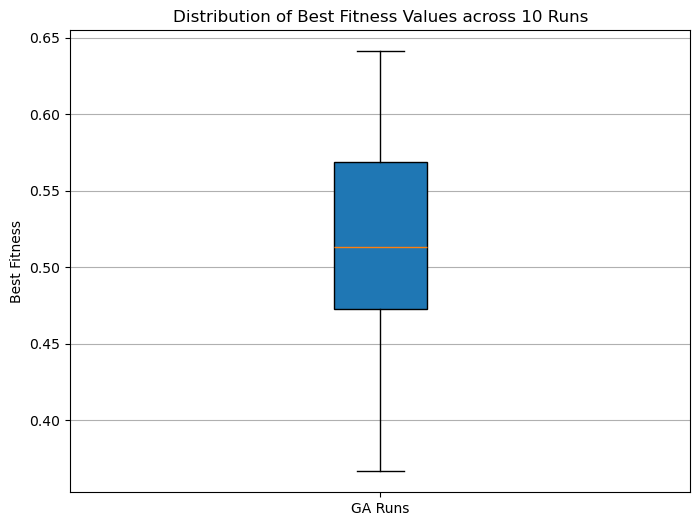

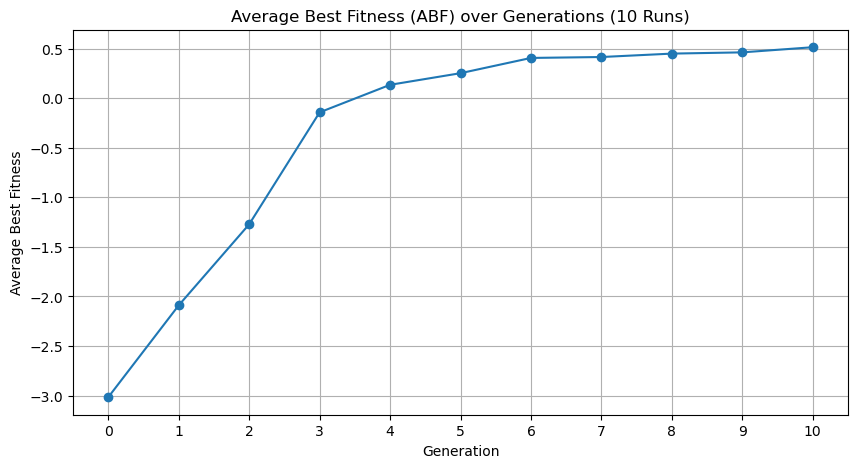


--- Analysis Complete ---
Final Best Fitness Values: [0.6226172438672442, 0.6410106560106555, 0.46584826284826275, 0.49406168831168834, 0.3994036796536796, 0.5786363636363635, 0.5297002442002442, 0.36679870129870096, 0.4964271284271283, 0.5380937950937947]


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from deap import base, creator, tools, algorithms
import random

# --- GA Parameters (Use the same as defined before or adjust if needed) ---
POP_SIZE = 100
CXPB = 0.7
MUTPB = 0.2
NGEN = 10 # Keep NGEN relatively low for faster testing, increase for better results
TOURNSIZE = 3
INDPB = 0.1
NUM_RUNS = 10 # Number of times to run the GA

# --- Data Collection ---
final_best_fitness_values = []
generational_max_fitness = [] # List to store max fitness per generation for each run

print(f"--- Running GA {NUM_RUNS} times ---")

for run in range(NUM_RUNS):
    print(f"\n--- Run {run + 1}/{NUM_RUNS} ---")
    # Re-initialize population for each run
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)

    # Setup statistics for this run
    stats_run = tools.Statistics(lambda ind: ind.fitness.values)
    stats_run.register("max", np.max)
    # We only need 'max' for the ABF plot, but keep others if desired for verbose output
    # stats_run.register("avg", np.mean)
    # stats_run.register("min", np.min)
    # stats_run.register("std", np.std)

    # Run the GA
    # Set verbose=False to avoid excessive output during multiple runs
    pop, logbook_run = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                            stats=stats_run, halloffame=hof, verbose=False)

    # Store results for this run
    best_fitness_run = hof[0].fitness.values[0]
    final_best_fitness_values.append(best_fitness_run)
    generational_max_fitness.append(logbook_run.select("max"))

    print(f"Run {run + 1} Best Fitness: {best_fitness_run}")

print(f"\n--- Finished {NUM_RUNS} runs ---")

# --- Analysis and Plotting ---

# 1. Boxplot of final best fitness values
plt.figure(figsize=(8, 6))
plt.boxplot(final_best_fitness_values, patch_artist=True)
plt.title(f'Distribution of Best Fitness Values across {NUM_RUNS} Runs')
plt.ylabel('Best Fitness')
plt.xticks([1], ['GA Runs'])
plt.grid(axis='y')
plt.show()

# 2. Line plot of Average Best Fitness (ABF) per generation
# Ensure all runs had the same number of generations (NGEN+1 points in logbook)
# Pad shorter runs if necessary (though eaSimple usually runs for exactly NGEN generations)
max_len = NGEN + 1 # Expected length of generational data
padded_fitness = []
for run_data in generational_max_fitness:
    if len(run_data) < max_len:
        # Pad with the last known value if a run finished early (unlikely with eaSimple)
        padded_run = run_data + [run_data[-1]] * (max_len - len(run_data))
        padded_fitness.append(padded_run)
    else:
        # Truncate if longer (also unlikely) or use as is
        padded_fitness.append(run_data[:max_len])


# Calculate Average Best Fitness (ABF)
abf_per_generation = np.mean(padded_fitness, axis=0)
generations = np.arange(len(abf_per_generation)) # 0 to NGEN

plt.figure(figsize=(10, 5))
plt.plot(generations, abf_per_generation, marker='o', linestyle='-')
plt.title(f'Average Best Fitness (ABF) over Generations ({NUM_RUNS} Runs)')
plt.xlabel('Generation')
plt.ylabel('Average Best Fitness')
plt.grid(True)
plt.xticks(np.arange(0, NGEN + 1, step=max(1, NGEN // 10))) # Adjust x-ticks for readability
plt.show()

print("\n--- Analysis Complete ---")
print(f"Final Best Fitness Values: {final_best_fitness_values}")
# print(f"Average Best Fitness per Generation: {abf_per_generation}") # Optional: print ABF values

--- Starting GA Operator Comparison (4 runs per combination) ---
Parameters: POP_SIZE=50, NGEN=4, CXPB=0.7, MUTPB=0.2, INDPB_MUT=0.1

Testing: Crossover=cxTwoPoint, Mutation=mutFlipBit*, Selection=selTournament
  *Note: Using mutUniformInt as mutFlipBit is unsuitable for integer lists.


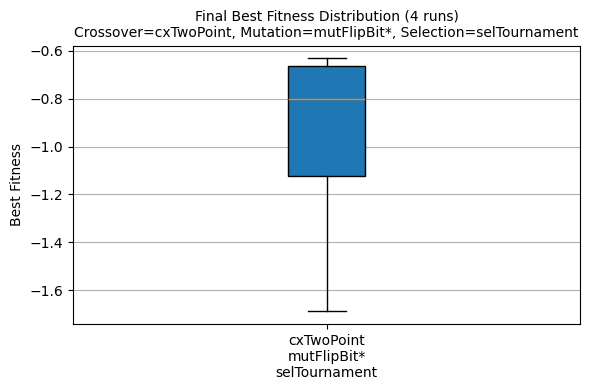

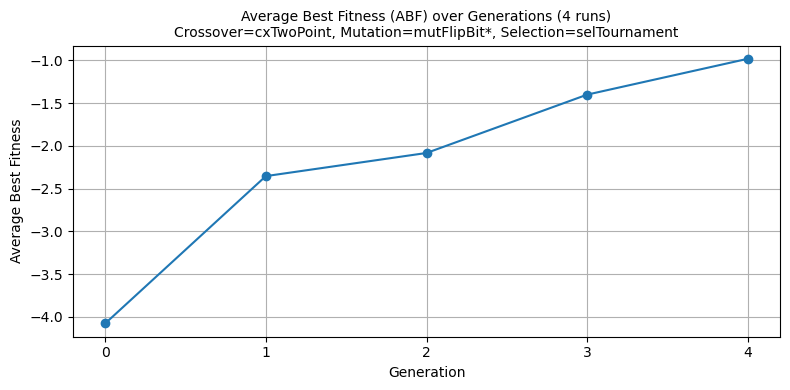

  Completed. Avg Time/Run: 7.37s, ABF (Last Gen): -0.9808

Testing: Crossover=cxTwoPoint, Mutation=mutFlipBit*, Selection=selRoulette
  *Note: Using mutUniformInt as mutFlipBit is unsuitable for integer lists.


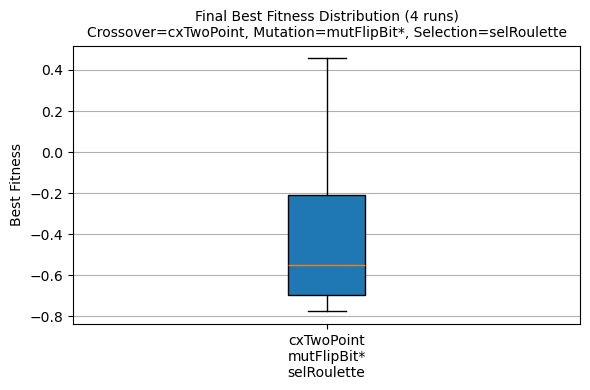

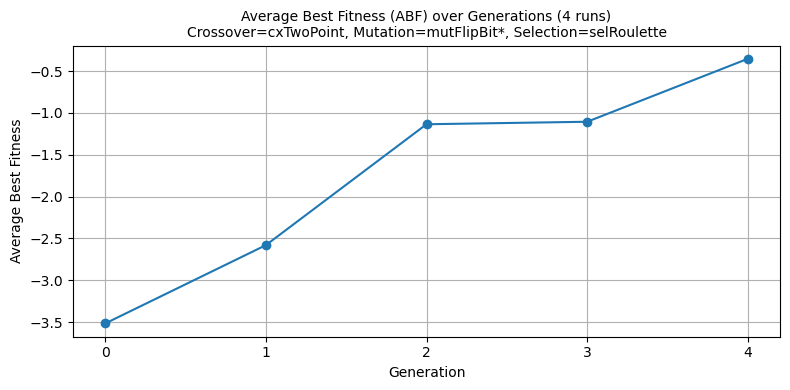

  Completed. Avg Time/Run: 8.81s, ABF (Last Gen): -0.3539

Testing: Crossover=cxTwoPoint, Mutation=mutShuffleIndexes, Selection=selTournament


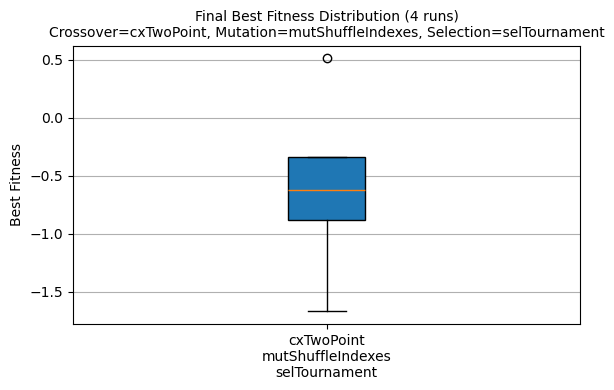

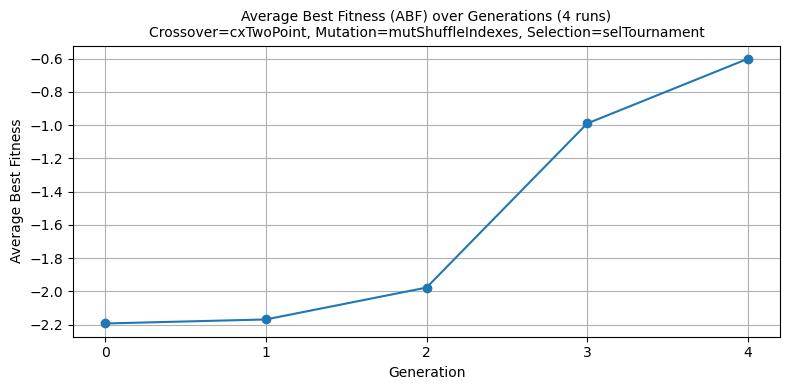

  Completed. Avg Time/Run: 6.51s, ABF (Last Gen): -0.6005

Testing: Crossover=cxTwoPoint, Mutation=mutShuffleIndexes, Selection=selRoulette


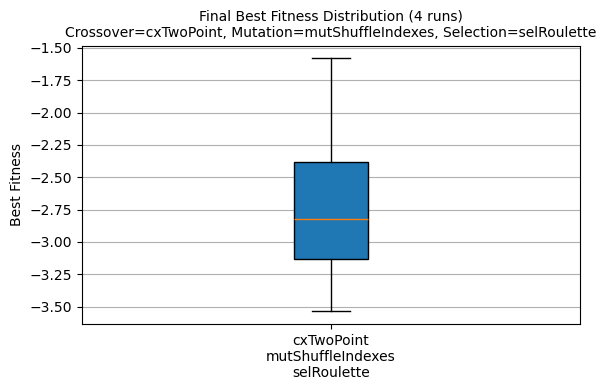

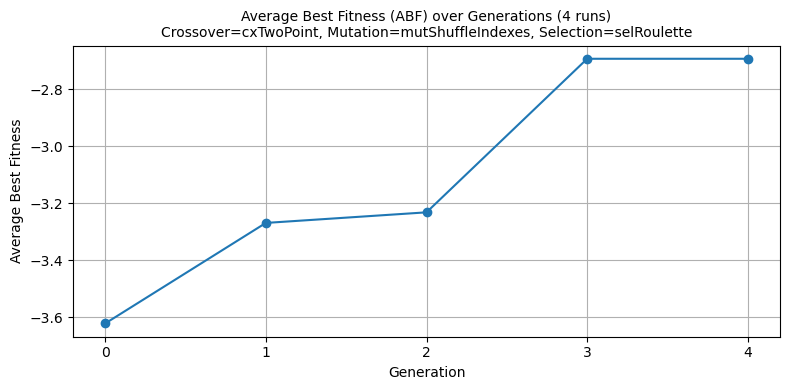

  Completed. Avg Time/Run: 8.76s, ABF (Last Gen): -2.6922

Testing: Crossover=cxOrdered, Mutation=mutFlipBit*, Selection=selTournament
  *Note: Using mutUniformInt as mutFlipBit is unsuitable for integer lists.


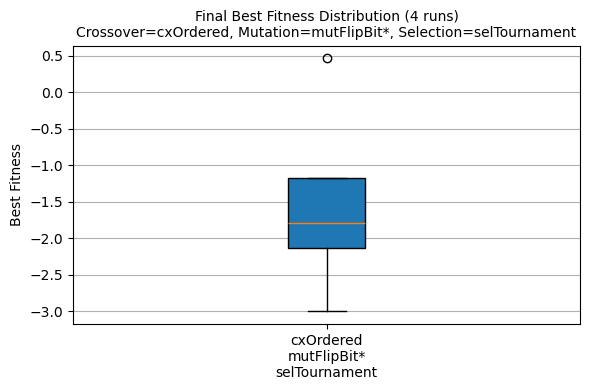

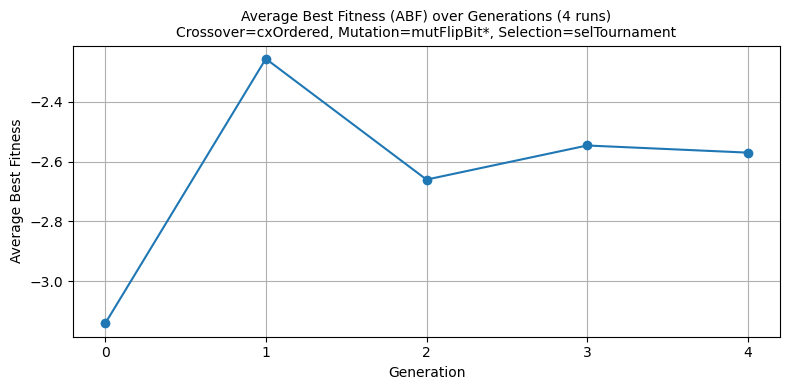

  Completed. Avg Time/Run: 5.06s, ABF (Last Gen): -2.5699

Testing: Crossover=cxOrdered, Mutation=mutFlipBit*, Selection=selRoulette
  *Note: Using mutUniformInt as mutFlipBit is unsuitable for integer lists.


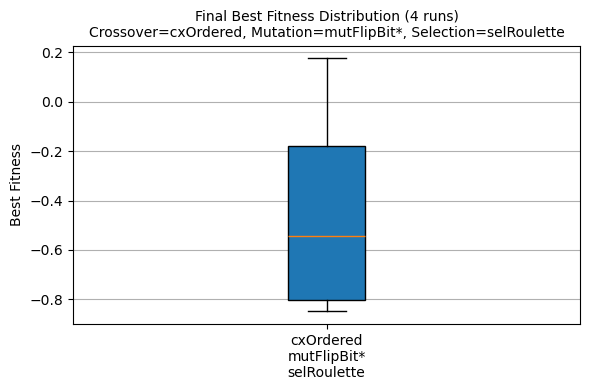

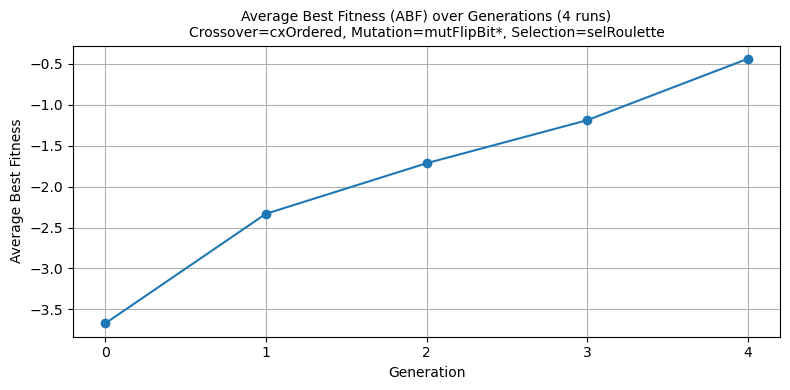

  Completed. Avg Time/Run: 7.21s, ABF (Last Gen): -0.4391

Testing: Crossover=cxOrdered, Mutation=mutShuffleIndexes, Selection=selTournament


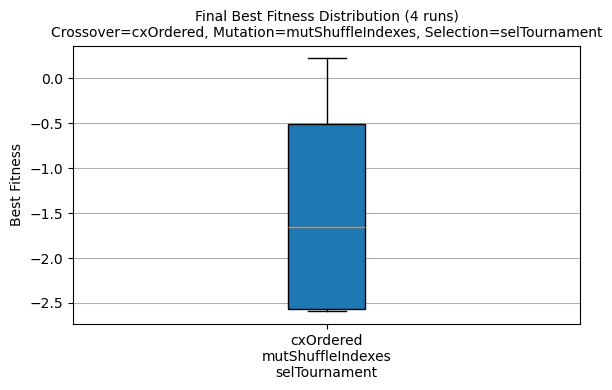

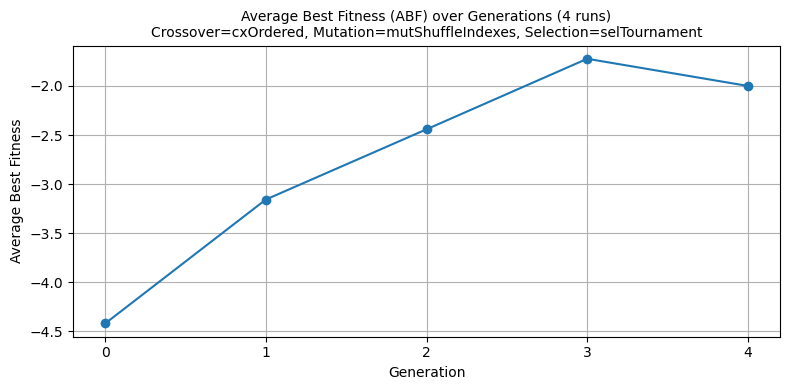

  Completed. Avg Time/Run: 6.50s, ABF (Last Gen): -1.9999

Testing: Crossover=cxOrdered, Mutation=mutShuffleIndexes, Selection=selRoulette


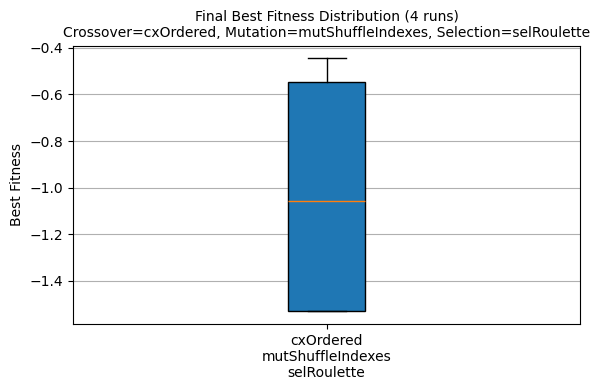

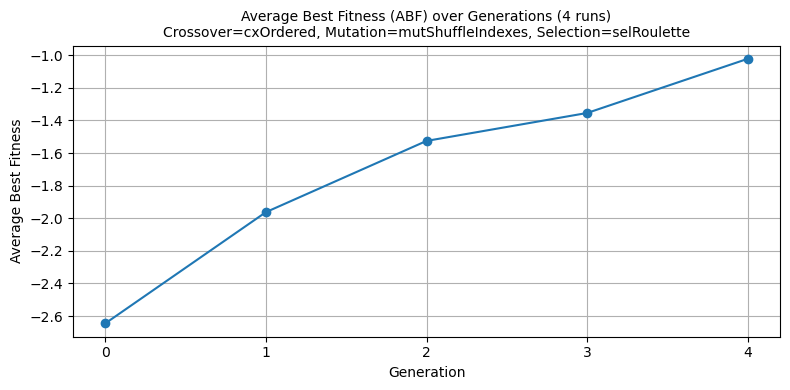

  Completed. Avg Time/Run: 13.33s, ABF (Last Gen): -1.0212


--- Overall Comparison Summary ---
 Crossover          Mutation     Selection  ABF (Last Gen)  Avg Time (s)
cxTwoPoint       mutFlipBit* selTournament         -0.9808        7.3714
cxTwoPoint       mutFlipBit*   selRoulette         -0.3539        8.8137
cxTwoPoint mutShuffleIndexes selTournament         -0.6005        6.5070
cxTwoPoint mutShuffleIndexes   selRoulette         -2.6922        8.7621
 cxOrdered       mutFlipBit* selTournament         -2.5699        5.0610
 cxOrdered       mutFlipBit*   selRoulette         -0.4391        7.2073
 cxOrdered mutShuffleIndexes selTournament         -1.9999        6.4978
 cxOrdered mutShuffleIndexes   selRoulette         -1.0212       13.3310

--- Best Combination (based on highest ABF) ---
Crossover          cxTwoPoint
Mutation          mutFlipBit*
Selection         selRoulette
ABF (Last Gen)      -0.353912
Avg Time (s)         8.813724
Name: 1, dtype: object


In [10]:
# ...existing code...
# Add this as a new cell

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import tools, algorithms, base, creator # Ensure these are imported
import random # Ensure random is imported

# --- GA Parameters ---
POP_SIZE = 50  # Keep population size manageable for testing
NGEN = 4       # Number of generations per run
NUM_RUNS = 4   # Number of runs per operator combination
CXPB = 0.7
MUTPB = 0.2
# INDPB for mutation (used by mutShuffleIndexes and mutUniformInt)
INDPB_MUT = 0.1
# Tournament size for selTournament
TOURNSIZE = 3

# --- Operator Combinations to Test ---
# Using names provided by the user, but substituting mutUniformInt for mutFlipBit
operator_combinations = [
    # Crossover                Mutation (Actual DEAP tool) Mutation Name  Selection            Selection Name
    (tools.cxTwoPoint,         tools.mutUniformInt,       "mutFlipBit*",   tools.selTournament, "selTournament"),
    (tools.cxTwoPoint,         tools.mutUniformInt,       "mutFlipBit*",   tools.selRoulette,   "selRoulette"),
    (tools.cxTwoPoint,         tools.mutShuffleIndexes,   "mutShuffleIndexes", tools.selTournament, "selTournament"),
    (tools.cxTwoPoint,         tools.mutShuffleIndexes,   "mutShuffleIndexes", tools.selRoulette,   "selRoulette"),
    (tools.cxOrdered,          tools.mutUniformInt,       "mutFlipBit*",   tools.selTournament, "selTournament"),
    (tools.cxOrdered,          tools.mutUniformInt,       "mutFlipBit*",   tools.selRoulette,   "selRoulette"),
    (tools.cxOrdered,          tools.mutShuffleIndexes,   "mutShuffleIndexes", tools.selTournament, "selTournament"),
    (tools.cxOrdered,          tools.mutShuffleIndexes,   "mutShuffleIndexes", tools.selRoulette,   "selRoulette"),
]

# --- DEAP Setup (Ensure FitnessMax and Individual are created) ---
# If not already created in a previous cell, uncomment these lines:
# if not hasattr(creator, "FitnessMax"):
#     creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# if not hasattr(creator, "Individual"):
#     creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, NR_PLACES - 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=NR_TRANSITIONS * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness) # Use the fitness function defined earlier

# --- Results Storage ---
results_summary = []

# --- Run Experiment ---
print(f"--- Starting GA Operator Comparison ({NUM_RUNS} runs per combination) ---")
print(f"Parameters: POP_SIZE={POP_SIZE}, NGEN={NGEN}, CXPB={CXPB}, MUTPB={MUTPB}, INDPB_MUT={INDPB_MUT}\n")

for mate_op, mutate_op, mutate_name, select_op, select_name in operator_combinations:
    mate_name = mate_op.__name__ # Get crossover name automatically
    combo_label = f"Crossover={mate_name}, Mutation={mutate_name}, Selection={select_name}"
    print(f"Testing: {combo_label}")
    if mutate_name == "mutFlipBit*":
        print("  *Note: Using mutUniformInt as mutFlipBit is unsuitable for integer lists.")

    # Register operators for the current combination
    toolbox.register("mate", mate_op)

    # Register mutation with appropriate parameters
    if mutate_op == tools.mutUniformInt:
         # Used for both mutUniformInt and as replacement for mutFlipBit
         toolbox.register("mutate", mutate_op, low=0, up=NR_PLACES - 1, indpb=INDPB_MUT)
    elif mutate_op == tools.mutShuffleIndexes:
         toolbox.register("mutate", mutate_op, indpb=INDPB_MUT)
    else:
         toolbox.register("mutate", mutate_op) # Should not happen with current list

    # Register selection with appropriate parameters
    if select_op == tools.selTournament:
        toolbox.register("select", select_op, tournsize=TOURNSIZE)
    else: # selRoulette
        toolbox.register("select", select_op)

    run_times = []
    final_fitnesses_for_combo = []
    generational_max_fitness_for_combo = [] # Store max fitness per gen for each run

    for run in range(NUM_RUNS):
        start_time = time.time()

        pop = toolbox.population(n=POP_SIZE)
        hof = tools.HallOfFame(1)
        stats_run = tools.Statistics(lambda ind: ind.fitness.values)
        stats_run.register("max", np.max)

        _, logbook_run = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN,
                                               stats=stats_run, halloffame=hof, verbose=False)

        end_time = time.time()
        run_times.append(end_time - start_time)

        if len(hof) > 0 and hof[0].fitness.valid:
            final_fitnesses_for_combo.append(hof[0].fitness.values[0])
            generational_max_fitness_for_combo.append(logbook_run.select("max"))
        else:
            final_fitnesses_for_combo.append(np.nan)
            # Ensure logbook has expected length even if run failed early
            max_fitness_log = logbook_run.select("max") if logbook_run else []
            padded_log = max_fitness_log + [np.nan] * (NGEN + 1 - len(max_fitness_log))
            generational_max_fitness_for_combo.append(padded_log[:NGEN+1])


    # --- Calculate Metrics and Plot for the Combination ---
    avg_time = np.nanmean(run_times) if run_times else 0

    # 1. Boxplot for the current combination
    plt.figure(figsize=(6, 4))
    plt.boxplot(final_fitnesses_for_combo, patch_artist=True)
    plt.title(f'Final Best Fitness Distribution ({NUM_RUNS} runs)\n{combo_label}', fontsize=10)
    plt.ylabel('Best Fitness')
    plt.xticks([1], [f'{mate_name}\n{mutate_name}\n{select_name}'])
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # 2. ABF Line Plot for the current combination
    # Pad generational data if runs had different lengths (unlikely with eaSimple but safe)
    max_len = NGEN + 1
    padded_fitness = []
    for run_data in generational_max_fitness_for_combo:
        if len(run_data) < max_len:
            padded_run = run_data + [run_data[-1] if run_data else np.nan] * (max_len - len(run_data))
            padded_fitness.append(padded_run[:max_len])
        else:
            padded_fitness.append(run_data[:max_len])

    abf_per_generation = np.nanmean(padded_fitness, axis=0)
    generations = np.arange(len(abf_per_generation)) # 0 to NGEN

    plt.figure(figsize=(8, 4))
    plt.plot(generations, abf_per_generation, marker='o', linestyle='-')
    plt.title(f'Average Best Fitness (ABF) over Generations ({NUM_RUNS} runs)\n{combo_label}', fontsize=10)
    plt.xlabel('Generation')
    plt.ylabel('Average Best Fitness')
    plt.xticks(np.arange(0, NGEN + 1, step=1)) # Show ticks for each generation
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Store Summary Results ---
    abf_last_gen = abf_per_generation[-1] if len(abf_per_generation) > 0 else np.nan
    print(f"  Completed. Avg Time/Run: {avg_time:.2f}s, ABF (Last Gen): {abf_last_gen:.4f}\n")

    results_summary.append({
        "Crossover": mate_name,
        "Mutation": mutate_name,
        "Selection": select_name,
        "ABF (Last Gen)": abf_last_gen,
        "Avg Time (s)": avg_time
    })

# --- Display Final Summary Table ---
print("\n--- Overall Comparison Summary ---")
if results_summary:
    results_df = pd.DataFrame(results_summary)
    # Reorder columns to match the requested table format
    results_df = results_df[["Crossover", "Mutation", "Selection", "ABF (Last Gen)", "Avg Time (s)"]]
    print(results_df.to_string(index=False, float_format="%.4f"))

    # Identify the best combination based on ABF
    # Handle potential NaN values in ABF before finding max
    valid_abf = results_df.dropna(subset=["ABF (Last Gen)"])
    if not valid_abf.empty:
        best_combo_idx = valid_abf["ABF (Last Gen)"].idxmax()
        best_combo = results_df.loc[best_combo_idx]
        print("\n--- Best Combination (based on highest ABF) ---")
        print(best_combo)
    else:
        print("\nCould not determine best combination (all ABF values were NaN).")

else:
    print("\nNo results generated.")

# Optional: Clean up toolbox registrations if running more experiments later
# del toolbox.mate
# del toolbox.mutate
# del toolbox.select

In [11]:
del toolbox.mate
del toolbox.mutate
del toolbox.select